In [1]:
from hyperimpute.plugins.imputers import Imputers, ImputerPlugin
from Impute import fill_with_et
from hyperimpute.plugins.utils.metrics import RMSE

imputers = Imputers()


class EtImputer(ImputerPlugin):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._model = fill_with_et

    @staticmethod
    def name():
        return "et"

    @staticmethod
    def hyperparameter_space():
        return []

    def _fit(self, *args, **kwargs):
        return self

    def _transform(self, df):
        # 按照缺失值的比例进行排序
        miss_rate = df.isnull().sum() / df.shape[0]
        cols = miss_rate.sort_values().index.tolist()
        cols = [col for col in cols if miss_rate[col] > 0]
        for col in cols:
            df_col_filled = self._model(df, col)
            df[col] = df_col_filled[col]
        return df


imputers.add("et", EtImputer)

hyper = imputers.get("hyperimpute", n_inner_iter=1)
et = imputers.get("et")
missforest = imputers.get("missforest")
gain = imputers.get("gain")
sinkhorn = imputers.get("sinkhorn")
mean = imputers.get("mean")

D:\software\miniconda\Lib\site-packages\pydantic\_internal\_fields.py:149: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
import pandas as pd

df = pd.read_csv("./dataset/Bala_regression_dataset.csv")
df

,Compound,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,BiFeO3-PT,0.20,0.80,1.0152,0.0878,816
1,BiFeO3-PT,0.30,0.70,1.0095,0.0935,840
2,BiFeO3-PT,0.40,0.60,1.0036,0.0994,864
3,BiFeO3-PT,0.50,0.50,0.9975,0.1055,915
4,BiFeO3-PT,0.60,0.40,0.9916,0.1114,956
...,...,...,...,...,...,...
127,Bi(ScIn)O3-PT,0.35,0.65,0.9854,0.0789,728
128,Bi(ScIn)O3-PT,0.37,0.63,0.9831,0.0791,718
129,Bi(ScGa)O3-PT,0.25,0.75,1.0057,0.0771,798
130,Bi(ScFe)O3-PT,0.40,0.60,0.9842,0.0839,728


In [3]:
df = df.drop(columns=['Compound'])
df

,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.20,0.80,1.0152,0.0878,816
1,0.30,0.70,1.0095,0.0935,840
2,0.40,0.60,1.0036,0.0994,864
3,0.50,0.50,0.9975,0.1055,915
4,0.60,0.40,0.9916,0.1114,956
...,...,...,...,...,...
127,0.35,0.65,0.9854,0.0789,728
128,0.37,0.63,0.9831,0.0791,718
129,0.25,0.75,1.0057,0.0771,798
130,0.40,0.60,0.9842,0.0839,728


In [19]:
from hyperimpute.plugins.utils.simulate import simulate_nan
import numpy as np

np.random.seed(42)
X = df.drop(labels=[], axis=1)
# reindex
cols = X.columns.tolist()
X = np.array(X)

sim_df = simulate_nan(X, 0.1, mecha="MAR")
X = pd.DataFrame(X, columns=cols)
X_with_nan = sim_df["X_incomp"]
mask = sim_df["mask"]
X_with_nan = pd.DataFrame(X_with_nan, columns=cols)
X_with_nan

,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.20,0.80,1.0152,NaN,816.0
1,0.30,0.70,1.0095,NaN,840.0
2,0.40,0.60,1.0036,0.0994,864.0
3,NaN,0.50,NaN,0.1055,915.0
4,0.60,0.40,NaN,0.1114,956.0
...,...,...,...,...,...
127,0.35,0.65,0.9854,0.0789,728.0
128,0.37,0.63,0.9831,0.0791,718.0
129,0.25,0.75,1.0057,0.0771,798.0
130,0.40,0.60,0.9842,0.0839,728.0


In [20]:
X_filled_et = et.fit_transform(X_with_nan.copy())
print("RMSE: ", RMSE(X.values, X_filled_et.values, mask))

X_filled_et

RMSE:  0.008172787062173914


,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.2000,0.80,1.015200,0.091198,816.0
1,0.3000,0.70,1.009500,0.078698,840.0
2,0.4000,0.60,1.003600,0.099400,864.0
3,0.5015,0.50,0.996482,0.105500,915.0
4,0.6000,0.40,0.984803,0.111400,956.0
...,...,...,...,...,...
127,0.3500,0.65,0.985400,0.078900,728.0
128,0.3700,0.63,0.983100,0.079100,718.0
129,0.2500,0.75,1.005700,0.077100,798.0
130,0.4000,0.60,0.984200,0.083900,728.0


In [21]:
X_filled_hyper = hyper.fit_transform(X_with_nan.copy())
print("RMSE: ", RMSE(X.values, X_filled_hyper.values, mask))

X_filled_hyper

RMSE:  0.03654123455190392


,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.200000,0.80,1.015200,0.081621,816.0
1,0.300000,0.70,1.009500,0.089672,840.0
2,0.400000,0.60,1.003600,0.099400,864.0
3,0.501989,0.50,0.994900,0.105500,915.0
4,0.600000,0.40,0.989159,0.111400,956.0
...,...,...,...,...,...
127,0.350000,0.65,0.985400,0.078900,728.0
128,0.370000,0.63,0.983100,0.079100,718.0
129,0.250000,0.75,1.005700,0.077100,798.0
130,0.400000,0.60,0.984200,0.083900,728.0


In [22]:
X_filled_missforest = missforest.fit_transform(X_with_nan.copy())
print("RMSE: ", RMSE(X.values, X_filled_missforest.values, mask))

X_filled_missforest

RMSE:  0.029785684260502286


,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.200000,0.80,1.015200,0.081411,816.0
1,0.300000,0.70,1.009500,0.089848,840.0
2,0.400000,0.60,1.003600,0.099400,864.0
3,0.529115,0.50,0.989184,0.105500,915.0
4,0.600000,0.40,0.988241,0.111400,956.0
...,...,...,...,...,...
127,0.350000,0.65,0.985400,0.078900,728.0
128,0.370000,0.63,0.983100,0.079100,718.0
129,0.250000,0.75,1.005700,0.077100,798.0
130,0.400000,0.60,0.984200,0.083900,728.0


In [23]:
X_filled_gain = gain.fit_transform(X_with_nan.copy())
print("RMSE: ", RMSE(X.values, X_filled_gain.values, mask))

X_filled_gain

RMSE:  0.07457266380262673


,0,1,2,3,4
0,0.200000,0.80,1.015200,0.079631,816.0
1,0.300000,0.70,1.009500,0.080916,840.0
2,0.400000,0.60,1.003600,0.099400,864.0
3,0.467287,0.50,0.991164,0.105500,915.0
4,0.600000,0.40,0.989969,0.111400,956.0
...,...,...,...,...,...
127,0.350000,0.65,0.985400,0.078900,728.0
128,0.370000,0.63,0.983100,0.079100,718.0
129,0.250000,0.75,1.005700,0.077100,798.0
130,0.400000,0.60,0.984200,0.083900,728.0


In [24]:
# set  X_filled_gain cols
X_filled_gain.columns = X.columns
X_filled_gain

,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.200000,0.80,1.015200,0.079631,816.0
1,0.300000,0.70,1.009500,0.080916,840.0
2,0.400000,0.60,1.003600,0.099400,864.0
3,0.467287,0.50,0.991164,0.105500,915.0
4,0.600000,0.40,0.989969,0.111400,956.0
...,...,...,...,...,...
127,0.350000,0.65,0.985400,0.078900,728.0
128,0.370000,0.63,0.983100,0.079100,718.0
129,0.250000,0.75,1.005700,0.077100,798.0
130,0.400000,0.60,0.984200,0.083900,728.0


In [25]:
X_filled_sinkhorn = sinkhorn.fit_transform(X_with_nan.copy())

print("RMSE: ", RMSE(X.values, X_filled_sinkhorn.values, mask))


RMSE:  0.08791287245347548


In [26]:
X_filled_sinkhorn.columns = X.columns

X_filled_sinkhorn

,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.200000,0.80,1.015200,0.086520,816.0
1,0.300000,0.70,1.009500,0.091688,840.0
2,0.400000,0.60,1.003600,0.099400,864.0
3,0.397604,0.50,1.000481,0.105500,915.0
4,0.600000,0.40,1.001274,0.111400,956.0
...,...,...,...,...,...
127,0.350000,0.65,0.985400,0.078900,728.0
128,0.370000,0.63,0.983100,0.079100,718.0
129,0.250000,0.75,1.005700,0.077100,798.0
130,0.400000,0.60,0.984200,0.083900,728.0


In [27]:
X_filled_mean = mean.fit_transform(X_with_nan.copy())

print("RMSE: ", RMSE(X.values, X_filled_mean.values, mask))

X_filled_mean.columns = X.columns
X_filled_mean

RMSE:  0.14227842977774638


,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
0,0.200000,0.80,1.015200,0.081124,816.0
1,0.300000,0.70,1.009500,0.081124,840.0
2,0.400000,0.60,1.003600,0.099400,864.0
3,0.277917,0.50,1.003317,0.105500,915.0
4,0.600000,0.40,1.003317,0.111400,956.0
...,...,...,...,...,...
127,0.350000,0.65,0.985400,0.078900,728.0
128,0.370000,0.63,0.983100,0.079100,718.0
129,0.250000,0.75,1.005700,0.077100,798.0
130,0.400000,0.60,0.984200,0.083900,728.0


In [28]:
missing_columns = X_with_nan.columns[X_with_nan.isnull().any()].tolist()
missing_columns

['xBi(Me1Me2)O3', 'Tolerance_Factor', 'Ionic_Displacements']

In [29]:
col = missing_columns[0]
col_mean = X[col].mean()
col_std = X[col].std()
# 统计在填充前缺失值在一个std距离内的缺失值
col_missing_index = X_with_nan[X_with_nan[col].isnull()].index
col_missing_values = X_with_nan.loc[col_missing_index, col]
original_values = X.loc[col_missing_index, col]
original_values

3      0.50
5      0.70
6      0.80
8      0.00
12     0.30
13     0.40
20     0.25
29     0.10
39     0.30
110    0.10
121    0.33
125    0.27
Name: xBi(Me1Me2)O3, dtype: float64

et: xBi(Me1Me2)O3 score_std: 0.04760757166504204, score_2std: 0.004280351923340627, score_3std: 0.06757595949629569
hyper: xBi(Me1Me2)O3 score_std: 0.09244012908145444, score_2std: 0.1903665863811972, score_3std: 0.7703704775059133
missforest: xBi(Me1Me2)O3 score_std: 0.10022557564589238, score_2std: 0.20436399564633398, score_3std: 0.580602258958801
gain: xBi(Me1Me2)O3 score_std: 0.23413963087994896, score_2std: 0.48849518906727696, score_3std: 1.5109324679629315
sinkhorn: xBi(Me1Me2)O3 score_std: 0.6220898010112536, score_2std: 0.8240140785694614, score_3std: 1.2612533430893689
mean: xBi(Me1Me2)O3 score_std: 0.32480886813199217, score_2std: 1.2434071934887334, score_3std: 2.7093131643225044
et: Tolerance_Factor score_std: 0.3716339554077903, score_2std: 0.3535247752256399, score_3std: nan
hyper: Tolerance_Factor score_std: 0.268448609236226, score_2std: 0.5871538050286021, score_3std: nan
missforest: Tolerance_Factor score_std: 0.33178467231704756, score_2std: 0.5547106461777325, sco

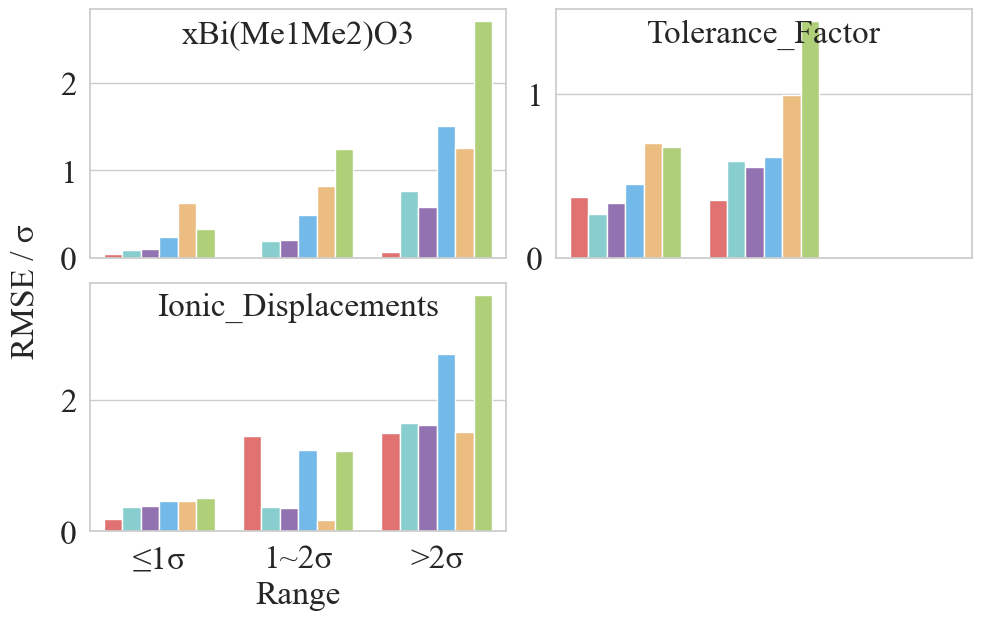

In [30]:
from scipy.stats import skew, kurtosis
import numpy as np
from sklearn.metrics import root_mean_squared_error as rmse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
my_palette = sns.color_palette(["#F35F5F", "#7ED9D9", "#9467BD", "#5FBDFF", "#FDBF6F", "#B3DE69", "#FFC0D9"])

cols = 2
rows = len(missing_columns) // cols if len(missing_columns) % cols == 0 else len(missing_columns) // cols + 1
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True)
axs = axs.flatten()

all_df = pd.DataFrame(columns=["RMSE", "Method", "Range", "Col"])

for col in missing_columns:
    ax = axs[missing_columns.index(col)]
    df = pd.DataFrame(columns=["RMSE", "Method", "Range"])

    col_mean = X[col].mean()
    col_std = X[col].std()
    # 统计在填充前缺失值在一个std距离内的缺失值
    col_missing_index = X_with_nan[X_with_nan[col].isnull()].index
    col_missing_values = X_with_nan.loc[col_missing_index, col]
    original_values = X.loc[col_missing_index, col]
    count = {"1": [], "2": [], "3": []}
    for idx, val in zip(col_missing_index, original_values):
        if abs(val - col_mean) > 2 * col_std:
            count["3"].append(idx)
        elif abs(val - col_mean) > 1 * col_std:
            count["2"].append(idx)
        else:
            count["1"].append(idx)
    col_mean = abs(col_mean)
    score_std = rmse(original_values[count["1"]], X_filled_et.loc[count["1"], col]) / col_std
    score_2std = rmse(original_values[count["2"]], X_filled_et.loc[count["2"], col]) / col_std if len(
        count["2"]) != 0 else np.nan
    score_3std = rmse(original_values[count["3"]], X_filled_et.loc[count["3"], col]) / col_std if len(
        count["3"]) != 0 else np.nan
    print(f"et: {col} score_std: {score_std}, score_2std: {score_2std}, score_3std: {score_3std}")
    df = pd.concat([df, pd.DataFrame({"RMSE": [score_std, score_2std, score_3std],
                                      "Method": ["MatImpute", "MatImpute", "MatImpute"],
                                      "Range": ["≤1σ", "1~2σ", ">2σ"]})], ignore_index=True)

    score_std = rmse(original_values[count["1"]], X_filled_hyper.loc[count["1"], col]) / col_std
    score_2std = rmse(original_values[count["2"]], X_filled_hyper.loc[count["2"], col]) / col_std if len(
        count["2"]) != 0 else np.nan
    score_3std = rmse(original_values[count["3"]], X_filled_hyper.loc[count["3"], col]) / col_std if len(
        count["3"]) != 0 else np.nan
    print(f"hyper: {col} score_std: {score_std}, score_2std: {score_2std}, score_3std: {score_3std}")
    df = pd.concat([df, pd.DataFrame({"RMSE": [score_std, score_2std, score_3std],
                                      "Method": ["HyperImpute", "HyperImpute", "HyperImpute"],
                                      "Range": ["≤1σ", "1~2σ", ">2σ"]})], ignore_index=True)

    score_std = rmse(original_values[count["1"]], X_filled_missforest.loc[count["1"], col]) / col_std
    score_2std = rmse(original_values[count["2"]], X_filled_missforest.loc[count["2"], col]) / col_std if len(
        count["2"]) != 0 else np.nan
    score_3std = rmse(original_values[count["3"]], X_filled_missforest.loc[count["3"], col]) / col_std if len(
        count["3"]) != 0 else np.nan
    print(f"missforest: {col} score_std: {score_std}, score_2std: {score_2std}, score_3std: {score_3std}")
    df = pd.concat([df, pd.DataFrame({"RMSE": [score_std, score_2std, score_3std],
                                      "Method": ["MissForest", "MissForest", "MissForest"],
                                      "Range": ["≤1σ", "1~2σ", ">2σ"]})], ignore_index=True)

    score_std = rmse(original_values[count["1"]], X_filled_gain.loc[count["1"], col]) / col_std
    score_2std = rmse(original_values[count["2"]], X_filled_gain.loc[count["2"], col]) / col_std if len(
        count["2"]) != 0 else np.nan
    score_3std = rmse(original_values[count["3"]], X_filled_gain.loc[count["3"], col]) / col_std if len(
        count["3"]) != 0 else np.nan
    print(f"gain: {col} score_std: {score_std}, score_2std: {score_2std}, score_3std: {score_3std}")
    df = pd.concat([df, pd.DataFrame({"RMSE": [score_std, score_2std, score_3std],
                                      "Method": ["Gain", "Gain", "Gain"],
                                      "Range": ["≤1σ", "1~2σ", ">2σ"]})], ignore_index=True)

    score_std = rmse(original_values[count["1"]], X_filled_sinkhorn.loc[count["1"], col]) / col_std
    score_2std = rmse(original_values[count["2"]], X_filled_sinkhorn.loc[count["2"], col]) / col_std if len(
        count["2"]) != 0 else np.nan
    score_3std = rmse(original_values[count["3"]], X_filled_sinkhorn.loc[count["3"], col]) / col_std if len(
        count["3"]) != 0 else np.nan
    print(f"sinkhorn: {col} score_std: {score_std}, score_2std: {score_2std}, score_3std: {score_3std}")
    df = pd.concat([df, pd.DataFrame({"RMSE": [score_std, score_2std, score_3std],
                                      "Method": ["Sinkhorn", "Sinkhorn", "Sinkhorn"],
                                      "Range": ["≤1σ", "1~2σ", ">2σ"]})], ignore_index=True)

    # mean
    score_std = rmse(original_values[count["1"]], X_filled_mean.loc[count["1"], col]) / col_std
    score_2std = rmse(original_values[count["2"]], X_filled_mean.loc[count["2"], col]) / col_std if len(
        count["2"]) != 0 else np.nan
    score_3std = rmse(original_values[count["3"]], X_filled_mean.loc[count["3"], col]) / col_std if len(
        count["3"]) != 0 else np.nan
    print(f"mean: {col} score_std: {score_std}, score_2std: {score_2std}, score_3std: {score_3std}")
    df = pd.concat([df, pd.DataFrame({"RMSE": [score_std, score_2std, score_3std],
                                      "Method": ["Mean", "Mean", "Mean"],
                                      "Range": ["≤1σ", "1~2σ", ">2σ"]})], ignore_index=True)
    df["Col"] = [col] * df.shape[0]
    all_df = pd.concat([all_df, df], ignore_index=True)

    df.drop(columns=["Col"], inplace=True)

    sns.barplot(x="Range", y="RMSE", hue="Method", data=df, ax=ax, palette=my_palette)
    # del legend
    ax.get_legend().remove()
    # del y label
    ax.set_ylabel("")
    ax.xaxis.set_tick_params(labelsize=24)
    ax.yaxis.set_tick_params(labelsize=24)
    # set x label size
    ax.set_xlabel("Range", fontsize=24)
    # 把标题添加到图的框内
    ax.text(0.5, 0.9, col, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
            fontsize=24)

# get legend
handles, labels = ax.get_legend_handles_labels()

# del empty subplot
for i in range(len(missing_columns), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
fig.text(0.02, 0.5, 'RMSE / σ', va='center', rotation='vertical', fontsize=24)
fig.subplots_adjust(hspace=0.1, wspace=0.12, left=0.1, bottom=0.1)
# plt.savefig("std-rmse.png", dpi=300)
all_df.to_excel("std-rmse-bala-reg.xlsx", index=False)